In [62]:
import qutip
# TODO implement this to make sure notebook runs correctly and can reproduce plots
# https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/lectures/Lecture-10-cQED-dispersive-regime.ipynb

In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Options, about, basis, coherent, correlation, destroy,
                   expect, mesolve, ptrace, qeye, sigmax, sigmaz,
                   spectrum_correlation_fft, tensor, wigner)

%matplotlib widget

In [64]:
N =  20 # should be much larger than average photon occupancy (>x10)
# but as increase N sim will be slower -> decrease drive amplitudes
# or to increase kappa for faster decay

wr = 2.0 * 2 * np.pi  # resonator frequency
wq = 3.0 * 2 * np.pi  # qubit frequency
chi = 0.025 * 2 * np.pi  # parameter in the dispersive hamiltonian

delta = abs(wr - wq)  # detuning
g = np.sqrt(delta * chi)  # coupling strength that is consistent with chi

In [65]:
# compare detuning and g, the first should be much larger than the second
delta / (2 * np.pi), g / (2 * np.pi)

(1.0, 0.15811388300841897)

In [66]:
# cavity operators
a = tensor(destroy(N), qeye(2))
nc = a.dag() * a
xc = a + a.dag()

# atomic operators
sm = tensor(qeye(N), destroy(2))
sz = tensor(qeye(N), sigmaz())
sx = tensor(qeye(N), sigmax())
nq = sm.dag() * sm
xq = sm + sm.dag()

Id = tensor(qeye(N), qeye(2))

In [67]:
def plotN_time(nc_list, nq_list):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 4))

    ax.plot(tlist, nc_list, "r", linewidth=2, label="cavity")
    ax.plot(tlist, nq_list, "b--", linewidth=2, label="qubit")
    ax.set_ylim(0, 7)
    ax.set_ylabel("n", fontsize=16)
    ax.set_xlabel("Time (ns)", fontsize=16)
    ax.legend()

    fig.tight_layout()
    return fig

In [68]:
# dispersive hamiltonian
# H0 is the time-independent part
H0 = wr * (a.dag() * a + Id / 2.0) + (wq / 2.0) * sz + chi *(a.dag() * a + Id / 2) * sz
# H0 = wr * (a.dag() * a) + wq * (sm.dag() * sm) + g* (a.dag()*sm + a*sm.dag())

# H1 + are the time-dependent terms
H1 = sm.dag() + sm

# NOTE this does not use RWA 

# TODO add ramp up time using tanh
def H1_coeff(t, args):
    wd = args['wd']
    return 20 * np.cos(wd * t) #np.exp(-((t-50) / 50) ** 2) 


# H1 + are the time-dependent terms
H2 = a.dag() + a

# NOTE this does not use RWA 
def H2_coeff(t, args):
    wd = args['wd']
    return 20 * np.cos(wd * t) #np.exp(-((t-50) / 50) ** 2) * 

# TODO add collapse operators

H = [H0, [H1, H1_coeff], [H2, H2_coeff]]

def setResFreq(f):
    wr = f * 2.0 * np.pi
    
    #recalc vals
    delta = abs(wr - wq)  # detuning
    g = np.sqrt(delta * chi)  # coupling strength that is consistent with chi

    H0 = wr * (a.dag() * a + Id / 2.0) + (wq / 2.0) * sz + chi *(a.dag() * a + Id / 2) * sz

    H = [H0, [H1, H1_coeff], [H2, H2_coeff]]

    
    psi0 = tensor(basis(N, 0), (basis(2, 0)).unit())
    args = {'wd': wq+.1*wq}
    tlist = np.linspace(0, 250, 1000)
    res = mesolve(H, psi0, tlist, [], [], options=Options(nsteps=5000), args=args)

    nc_list = expect(nc, res.states)
    nq_list = expect(nq, res.states)
    plotN_time(nc_list, nq_list)

def setQubitFreq(f):
    wq = f * 2.0 * np.pi
    
    #recalc vals
    delta = abs(wr - wq)  # detuning
    g = np.sqrt(delta * chi)  # coupling strength that is consistent with chi

    H0 = wr * (a.dag() * a + Id / 2.0) + (wq / 2.0) * sz + chi *(a.dag() * a + Id / 2) * sz

    H = [H0, [H1, H1_coeff], [H2, H2_coeff]]

    
    psi0 = tensor(basis(N, 0), (basis(2, 0)).unit())
    args = {'wd': wq+.1*wq}
    tlist = np.linspace(0, 250, 1000)
    res = mesolve(H, psi0, tlist, [], [], options=Options(nsteps=5000), args=args)

    nc_list = expect(nc, res.states)
    nq_list = expect(nq, res.states)

    f = plotN_time(nc_list, nq_list )
    f.show()


In [69]:
psi0 = tensor(basis(N, 0), (basis(2, 0)).unit())

In [70]:

args = {'wd': wq+.1*wq}
tlist = np.linspace(0, 250, 1000)
res = mesolve(H, psi0, tlist, [], [], options=Options(nsteps=5000), args=args)



In [71]:
nc_list = expect(nc, res.states)
nq_list = expect(nq, res.states)

18.84955592153876
18.84955592153876
18.84955592153876


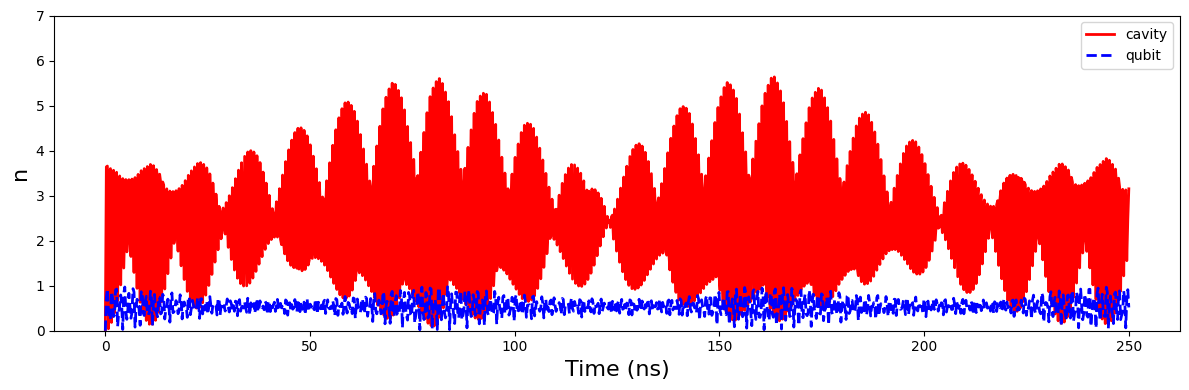

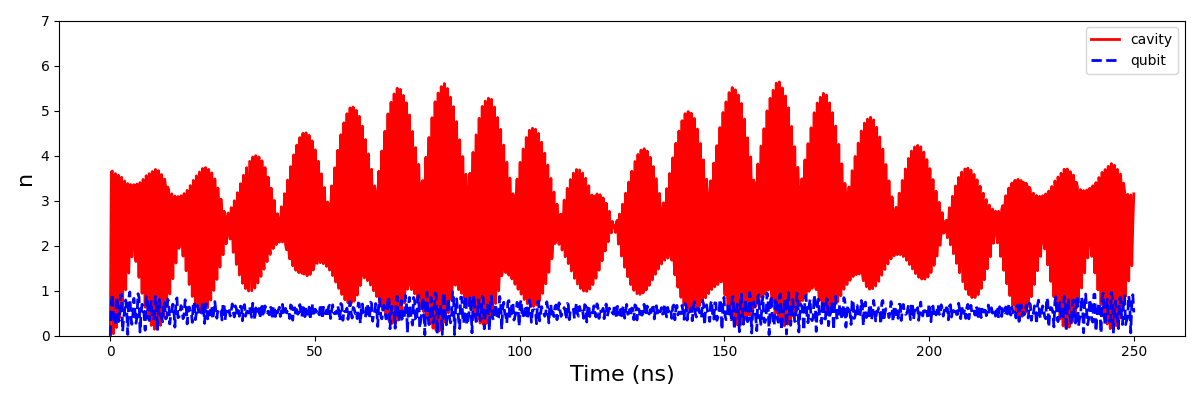

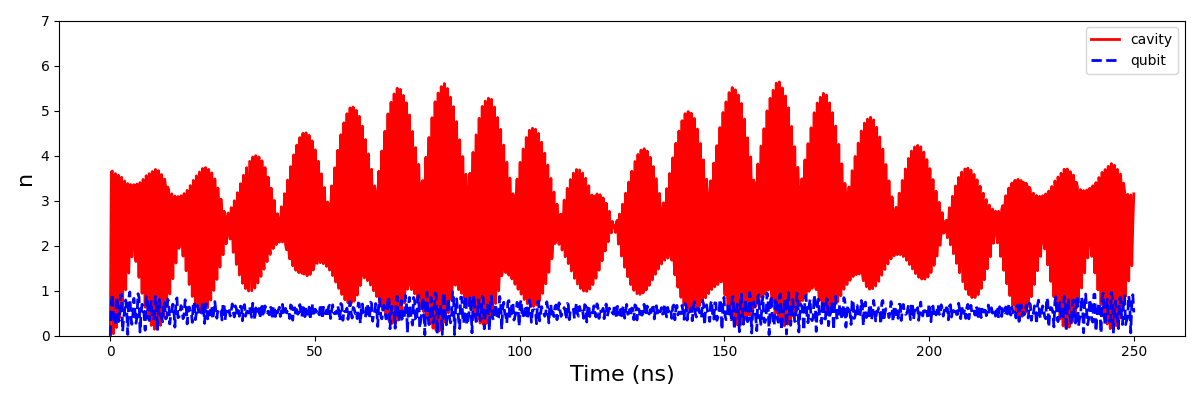

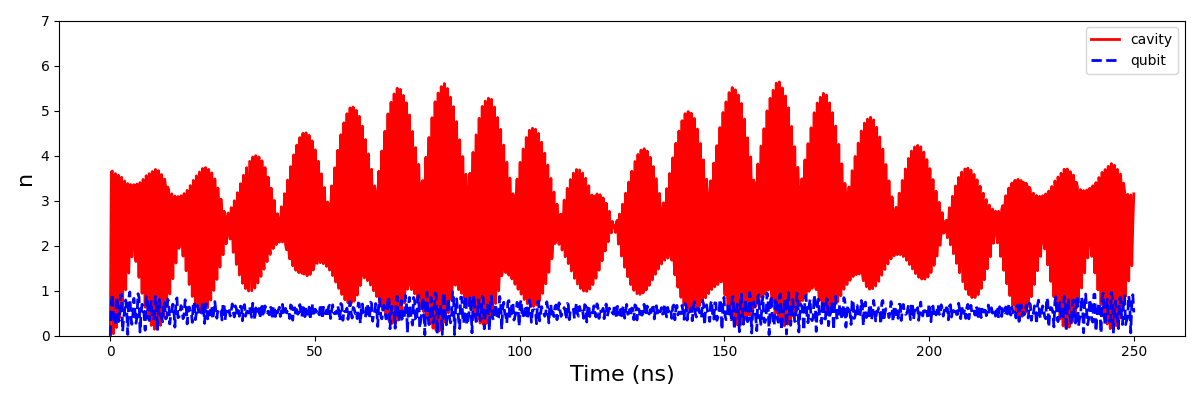

In [11]:
# TODO plot steady state n value in qubit drive frequency domain

In [12]:
print(nc_list[-1])

3.1511297650279584


In [13]:
print(nc_list[-1])

3.1511297650279584
